<br>

<center>
    <span style="font-size:24px; font-weight:bold;">Outfit Scoring Application - Clothing Annotation + Instance Segmentation</span>
</center>

<br>

<hr style="border: none; border-top: 1px solid #000;">

<center>
    <span>
        Created by <b>Ian Yap</b>
        &emsp;|&emsp;
        Data from <b>Google Images</b>
        <!-- Data from <a href="https://www"><b>Kaggle</b></a> -->
    </span>
</center>

<br>

<center>
    <span>
        <a href="https://www.linkedin.com/in/ian-yap-052870139/"><b>LinkedIn</b></a>
        &emsp;|&emsp;
        <a href="https://xiyap.github.io/"><b>Portfolio</b></a>
    </span>
</center>
    
<hr style="border: none; border-top: 1px solid #000;">


<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Objective</span>

The goal of this project is to **develop an 'Outfit Scoring Application' that identifies an individual's outfit, evaluates it based on the garments worn, and provides recommendations to enhance its rating.**

This application will utilize a clothing segmentation model which will be trained using a custom dataset consisting of various outfits.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Initial Wireframe</span>

Visualized initial idea of model function:

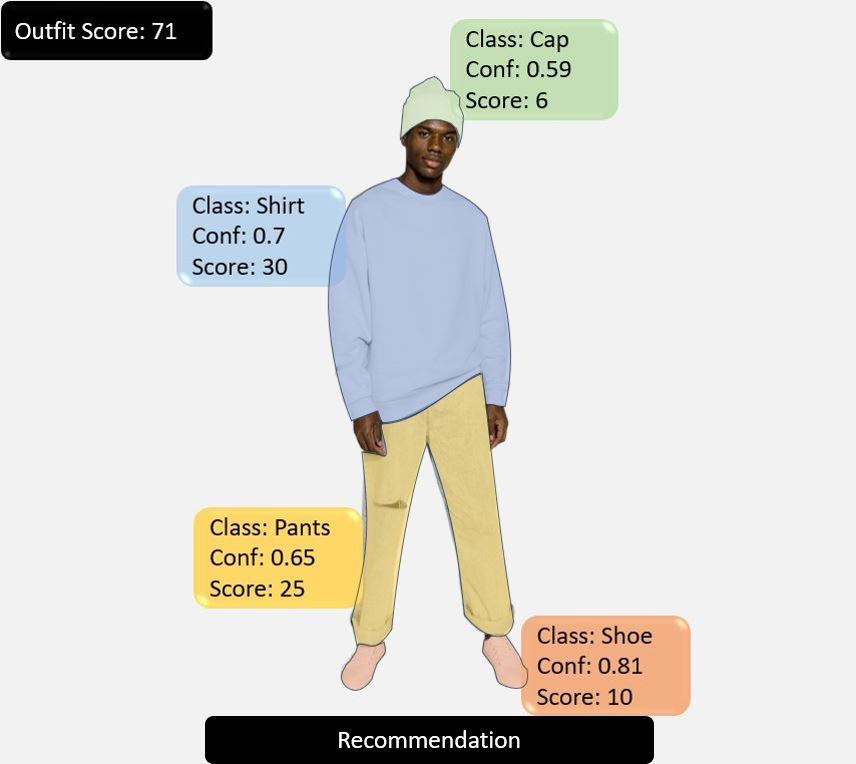

In [1]:
import glob
from IPython.display import display, Image

Image('data-notebook/wireframe.jpg', width = 600)

The segmented classes should cover the general terms commonly used to describe clothing items:
1. Cap
2. Glasses
3. Shirt
4. Pants
5. Socks
6. Shoe
7. Slipper

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Install Dependencies and Setup</span>

In [2]:
# !pip list

In [3]:
import os
import shutil
import random
import cv2
import cvzone
import colorsys
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
seed = 101
random.seed(seed)
np.random.seed(seed)

In [5]:
import torch
from ultralytics import YOLO
torch.cuda.is_available()

True

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Gather Data</span>

Obtain a training dataset for our model by utilizing simple_image_download to download Google images in batches using relevant search terms:
- **shirt model**
- **pants model**
- **short pants male model**
- **sock on feet**
- **flat slipper**
- **cap style**
- **glasses style**
- **sneaker style**

In [ ]:
import simple_image_download as simp

response = simp.simple_image_download

keywords = ['shirt model', 'pants model', 'short pants male model', 
            'sock on feet', 'flat slipper', 'cap style', 
            'glasses style', 'sneaker style']

for kw in keywords:
    response().download(kw, 100)

Sample Data:


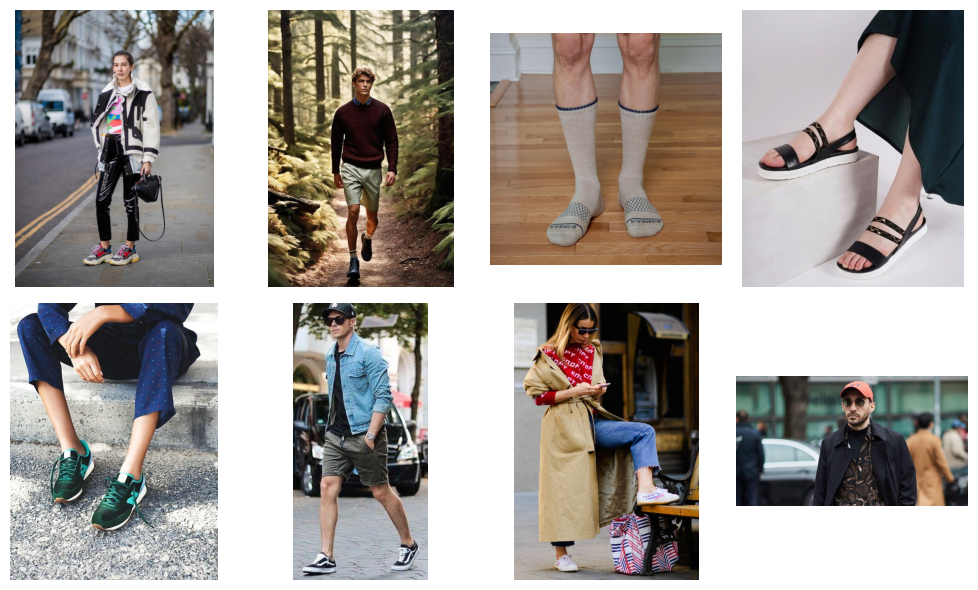

In [11]:
print('Sample Data:')

plt.figure(figsize = (10, 6))

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    random_image_file = random.choice(os.listdir('data/train/images'))
    random_image_path = os.path.join('data/train/images', random_image_file)
    img = cv2.imread(random_image_path)
#     img = cv2.resize(img, (400, 400))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show();

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Remove Unsupported Images</span>

Remove images with unsupported formats:

labelme supported formats:
- **.jpeg**
- **.jpg**
- **.png**

In [ ]:
from pathlib import Path

# Image directory
data_dir = Path('data/train/images')

# labelme formats
image_exts = ['.jpeg', '.jpg', '.png']

for image_file in data_dir.iterdir():
    if image_file.suffix.lower() not in image_exts:
        print(f'{image_file} (Removed due to incompatible format)')
#         image_file.unlink()
    else:
        try:
            img = cv2.imread(str(image_file))
            if img is None:
                print(f'{image_file} (Invalid image format)')
#                 image_file.unlink()
        except Exception as e:
            print(f'{image_file}: {e} (Issue with image)')
#             image_file.unlink()

The images are also manually inspected and removed if deemed unsuitable.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Label Images</span>

Annotate images into the following classes using labelme with assistance of EfficientSam AI Model to speed up the process:
- **sock**
- **shoe**
- **pants**
- **glasses**
- **shirt**
- **slipper**
- **cap**

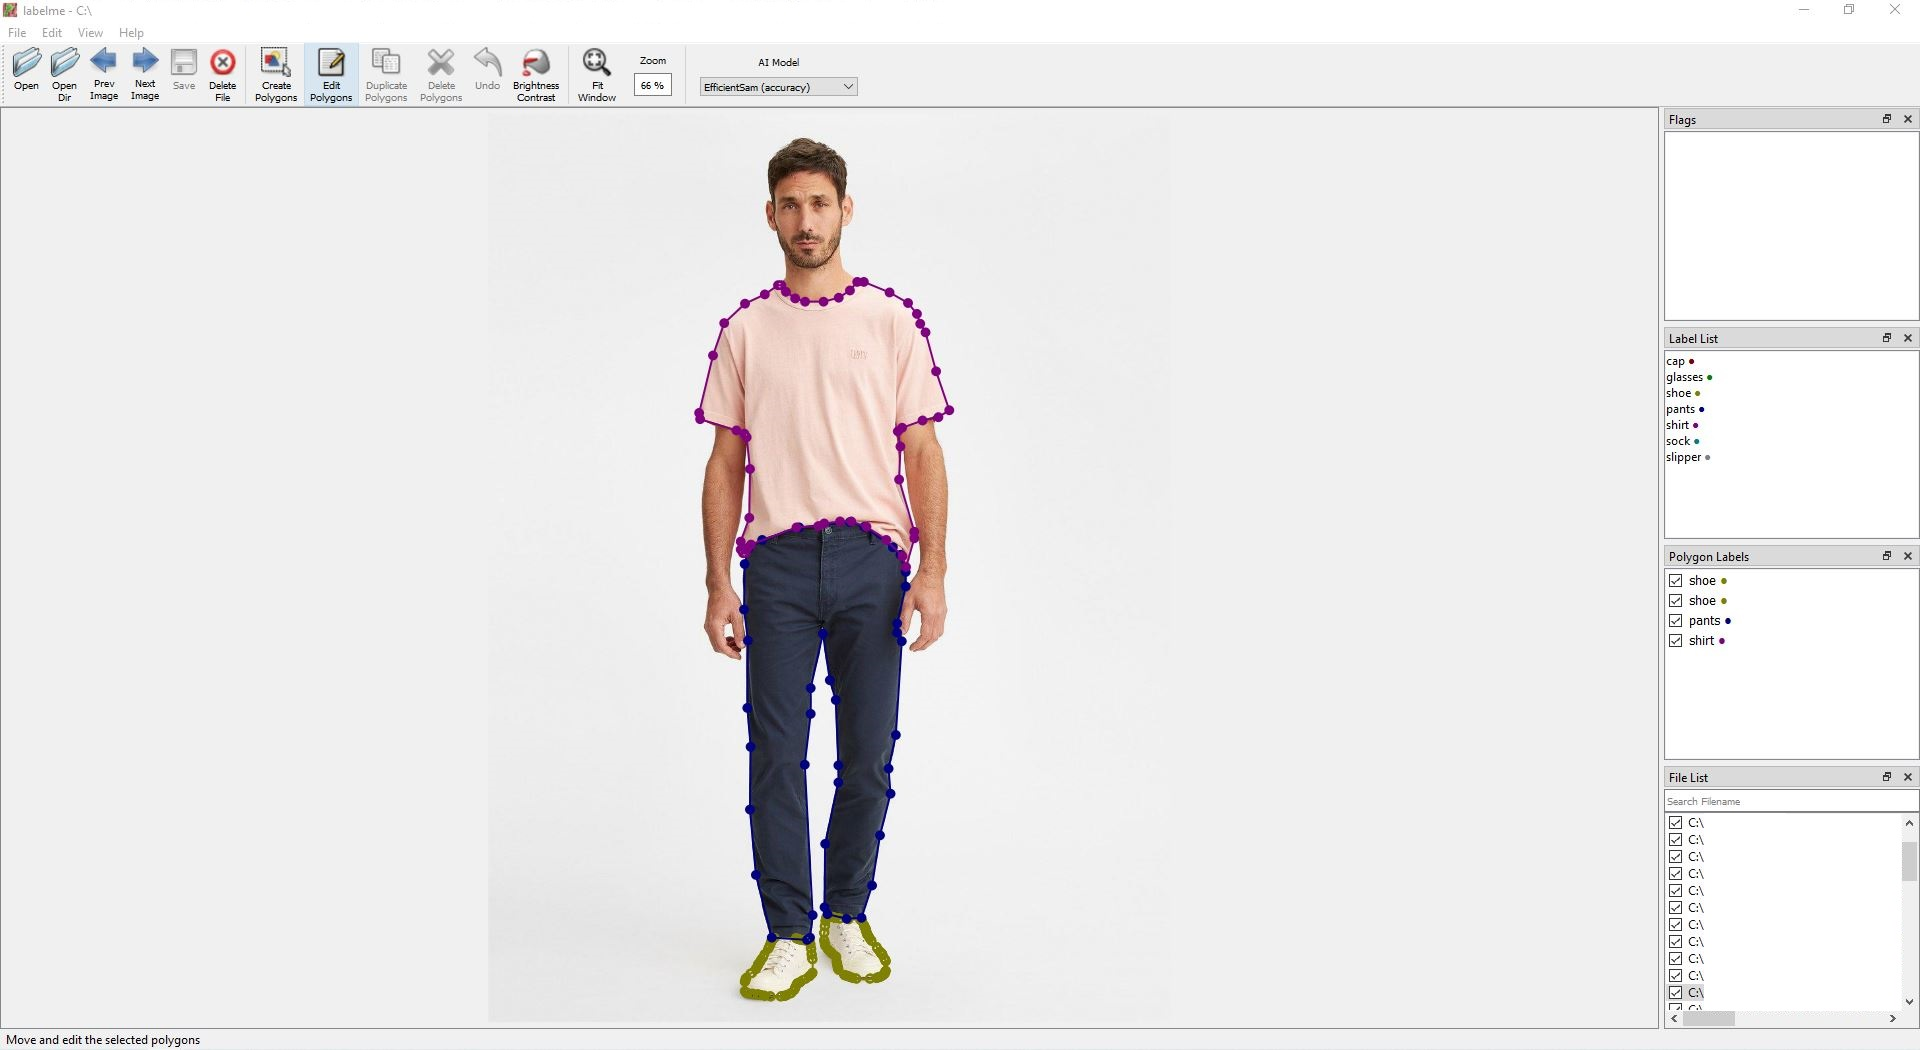

In [6]:
Image('data-notebook/labelme.jpg')

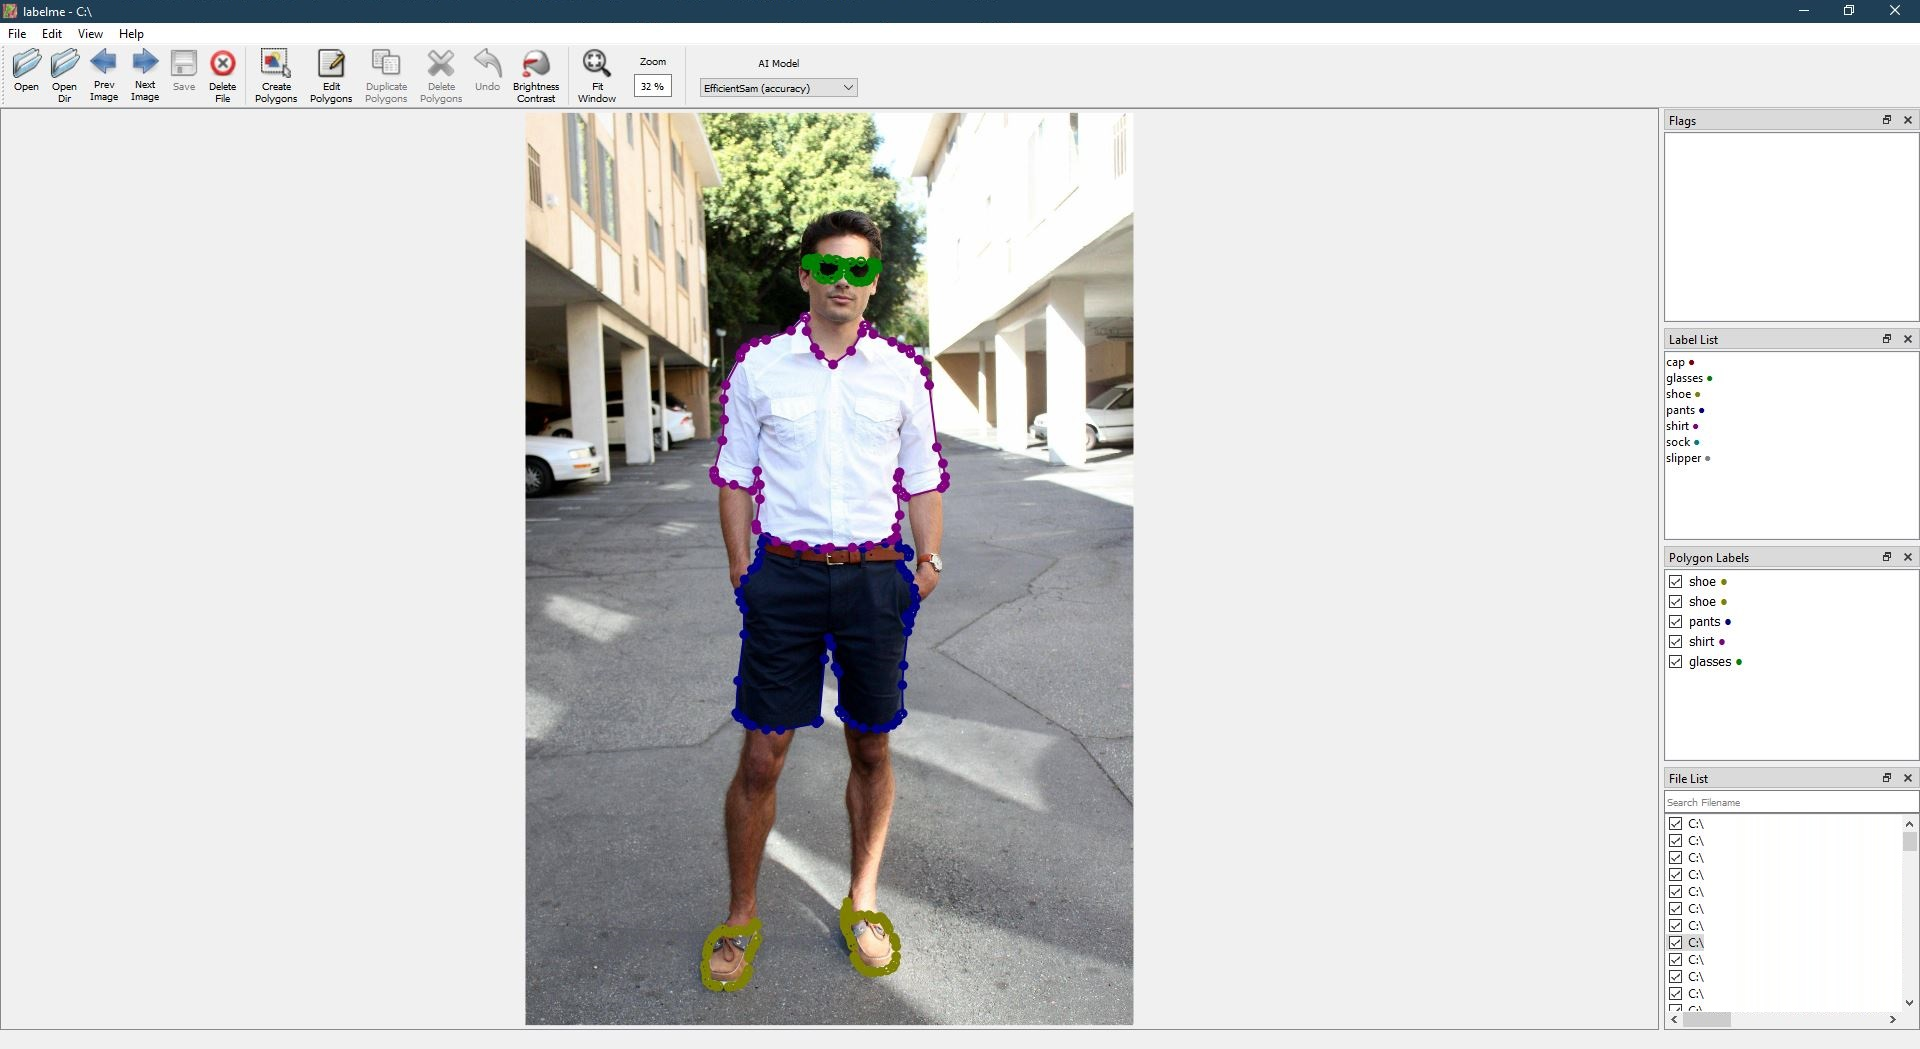

In [7]:
Image('data-notebook/labelme2.jpg')

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Annotation Preparation</span>

1. Convert image annotation from **JSON file to YOLO text format** utilizing labelme2yolo tool.
2. Split dataset into training **(80%)** and validation set **(20%)**.

In [ ]:
!labelme2yolo --json_dir data/train/images --val_size 0.2

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Model Training</span>

As our dataset contains only 353 images for 7 different classes, the nano segmentation YOLO model will be used to prevent overfitting and poor generalisation from using a model too complex for the data:

In [8]:
model_n_seg = YOLO('yolov8n-seg.pt')

In [ ]:
model_n_seg.train(data = 'config.yaml',
                  epochs = 100,
                  batch = 1,
                  workers = 0,
                  seed = seed
                 )

In [10]:
best_nano_seg_1 = 'runs/segment/train/weights/best.pt'
model_n_seg_1 = YOLO(best_nano_seg_1)

In [11]:
model_n_seg_1.val();

Ultralytics YOLOv8.1.3 🚀 Python-3.8.0 torch-1.9.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259429 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\data\val\label
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAPException in thread Thread-98:
Traceback (most recent call last):
  File "C:\Users\xiani\anaconda3\envs\tf_gpu\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\xiani\anaconda3\envs\tf_gpu\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\xiani\anaconda3\envs\tf_gpu\lib\site-packages\ultralytics\utils\plotting.py", line 759, in plot_images
    im = np.asarray(annotator.im).copy()
numpy.core._exceptions.MemoryError: Unable to allocate 10.5 MiB for an array with shape (1920, 1920, 3) and data type uint8
Exception in thread Exception in thread Thread-101:
Traceback (most recent call last):
  File "C:\Users\xiani\anaconda3\envs\tf_gpu\lib\threading.py", line 932, in _bootstrap

                   all         71        186       0.75      0.735      0.784      0.646      0.748      0.715      0.764      0.613
                  sock         71         18      0.704      0.661      0.653      0.503      0.693      0.629      0.652      0.487
                  shoe         71         43       0.77      0.744      0.835      0.642       0.76      0.698      0.811      0.625
                 pants         71         42      0.851       0.68      0.809        0.7       0.85      0.673       0.81      0.669
               glasses         71         21      0.665      0.857       0.77      0.572      0.691       0.85       0.77      0.577
                 shirt         71         32      0.657      0.656      0.661      0.599      0.664      0.656      0.646      0.562
               slipper         71         20      0.788      0.743      0.865        0.7      0.759        0.7      0.762      0.578
                   cap         71         10      0.816        0.8   

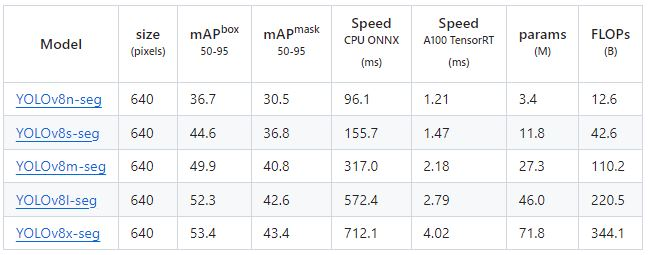

In [12]:
Image('Data-notebook/yolov8_seg_models.jpg')

By comparing the validation mean average precision score across 50% to 95% confidence threshold (mAP val 50-95) for the mask, the custom trained nano model **(model_n_seg_1)** has a higher score of 61.3% compared to the YOLOv8n-seg baseline score of 30.5%. This proves that the custom training is working in teaching the pre-trained model to recognize the objects in our application by updating the weights of the dense layers. The mAP val 50-95 score for each class is also higher than the baseline.

Let's explore the dataset and training results:

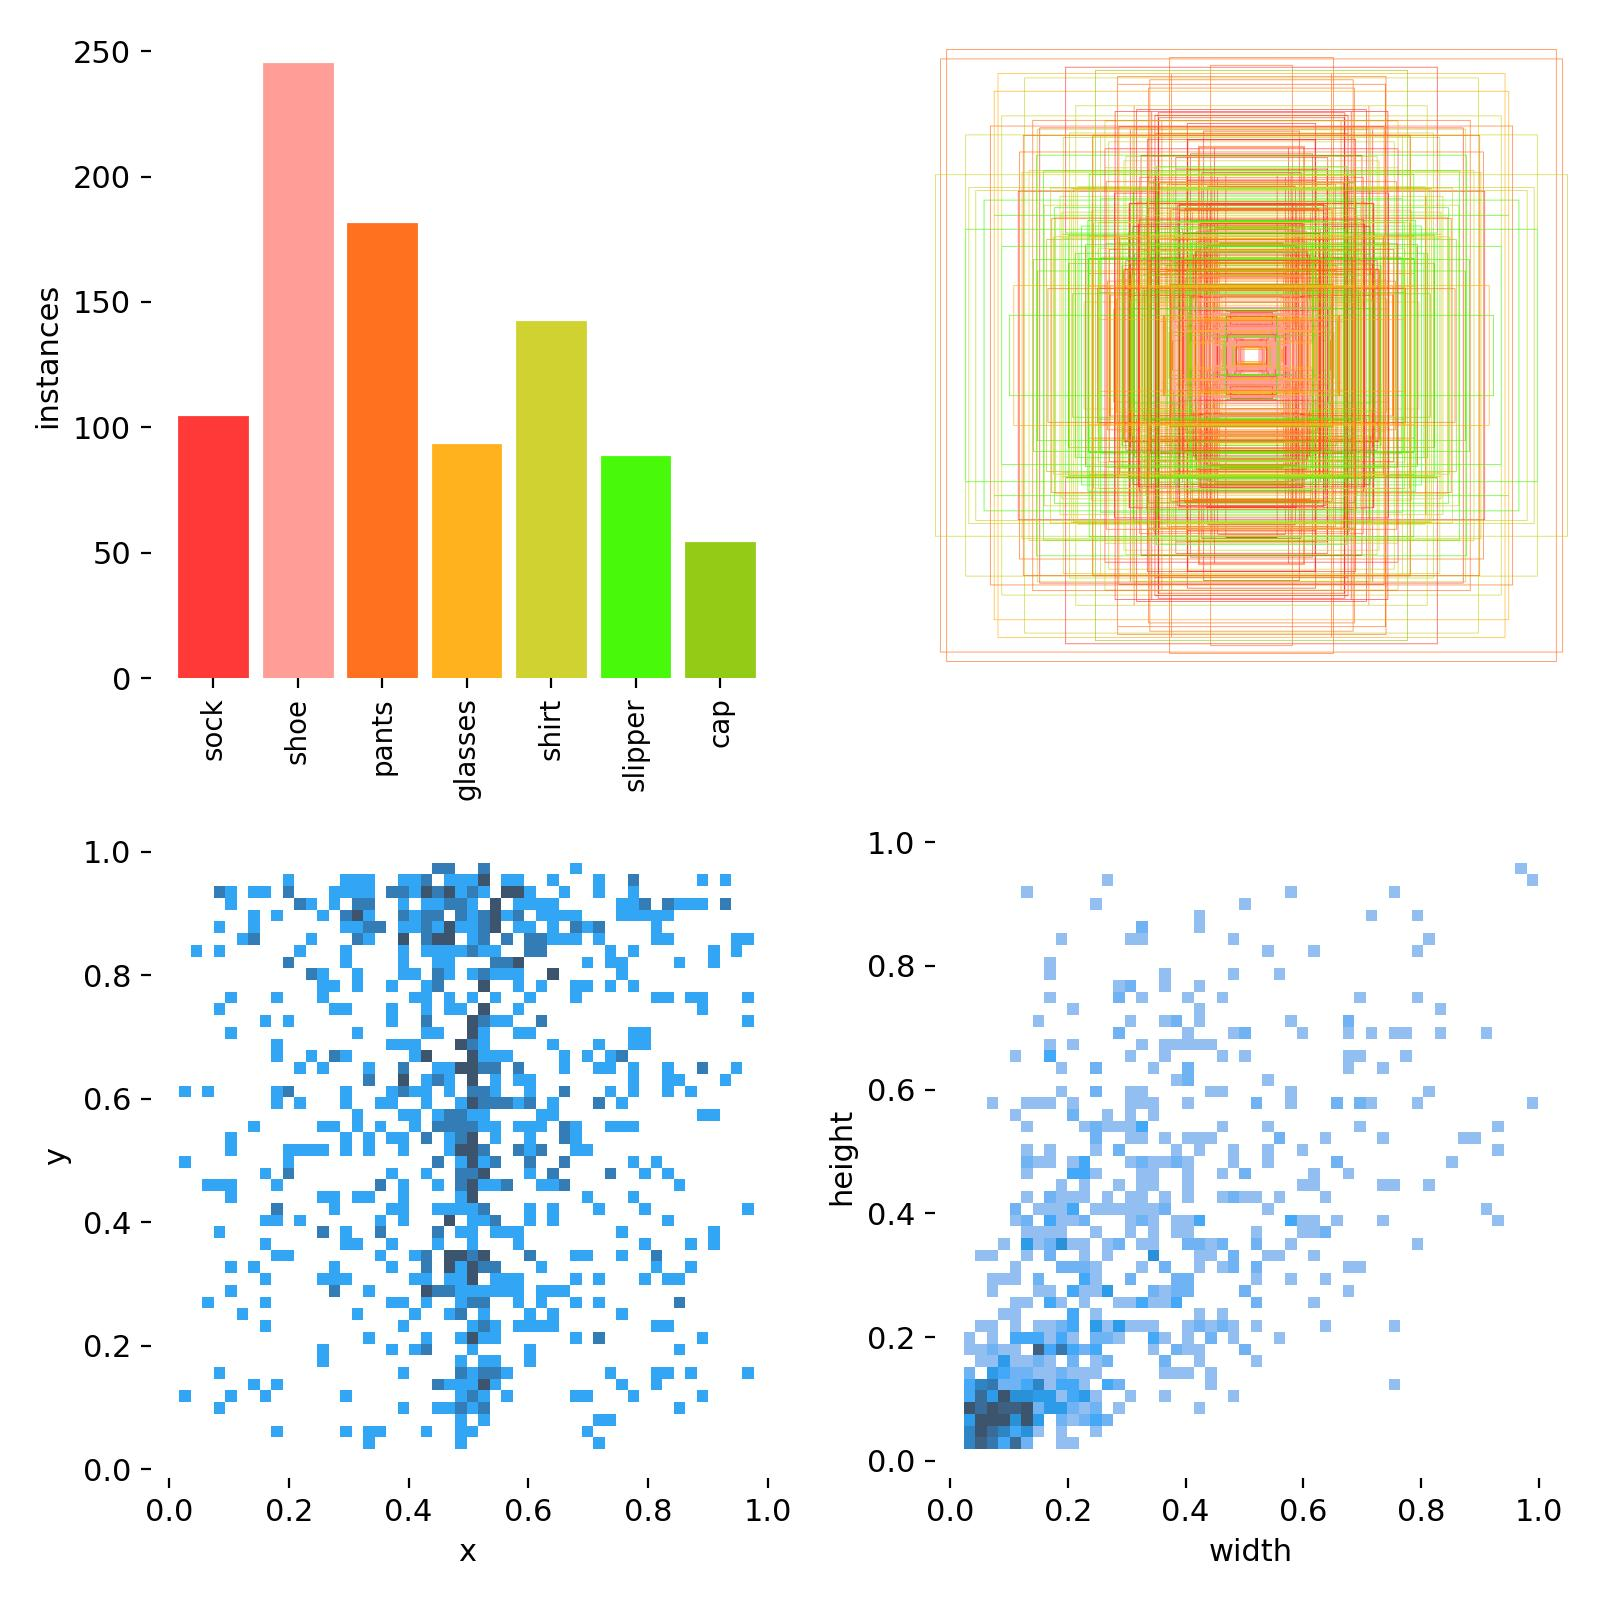

In [13]:
Image('runs/segment/train/labels.jpg', width = 600)

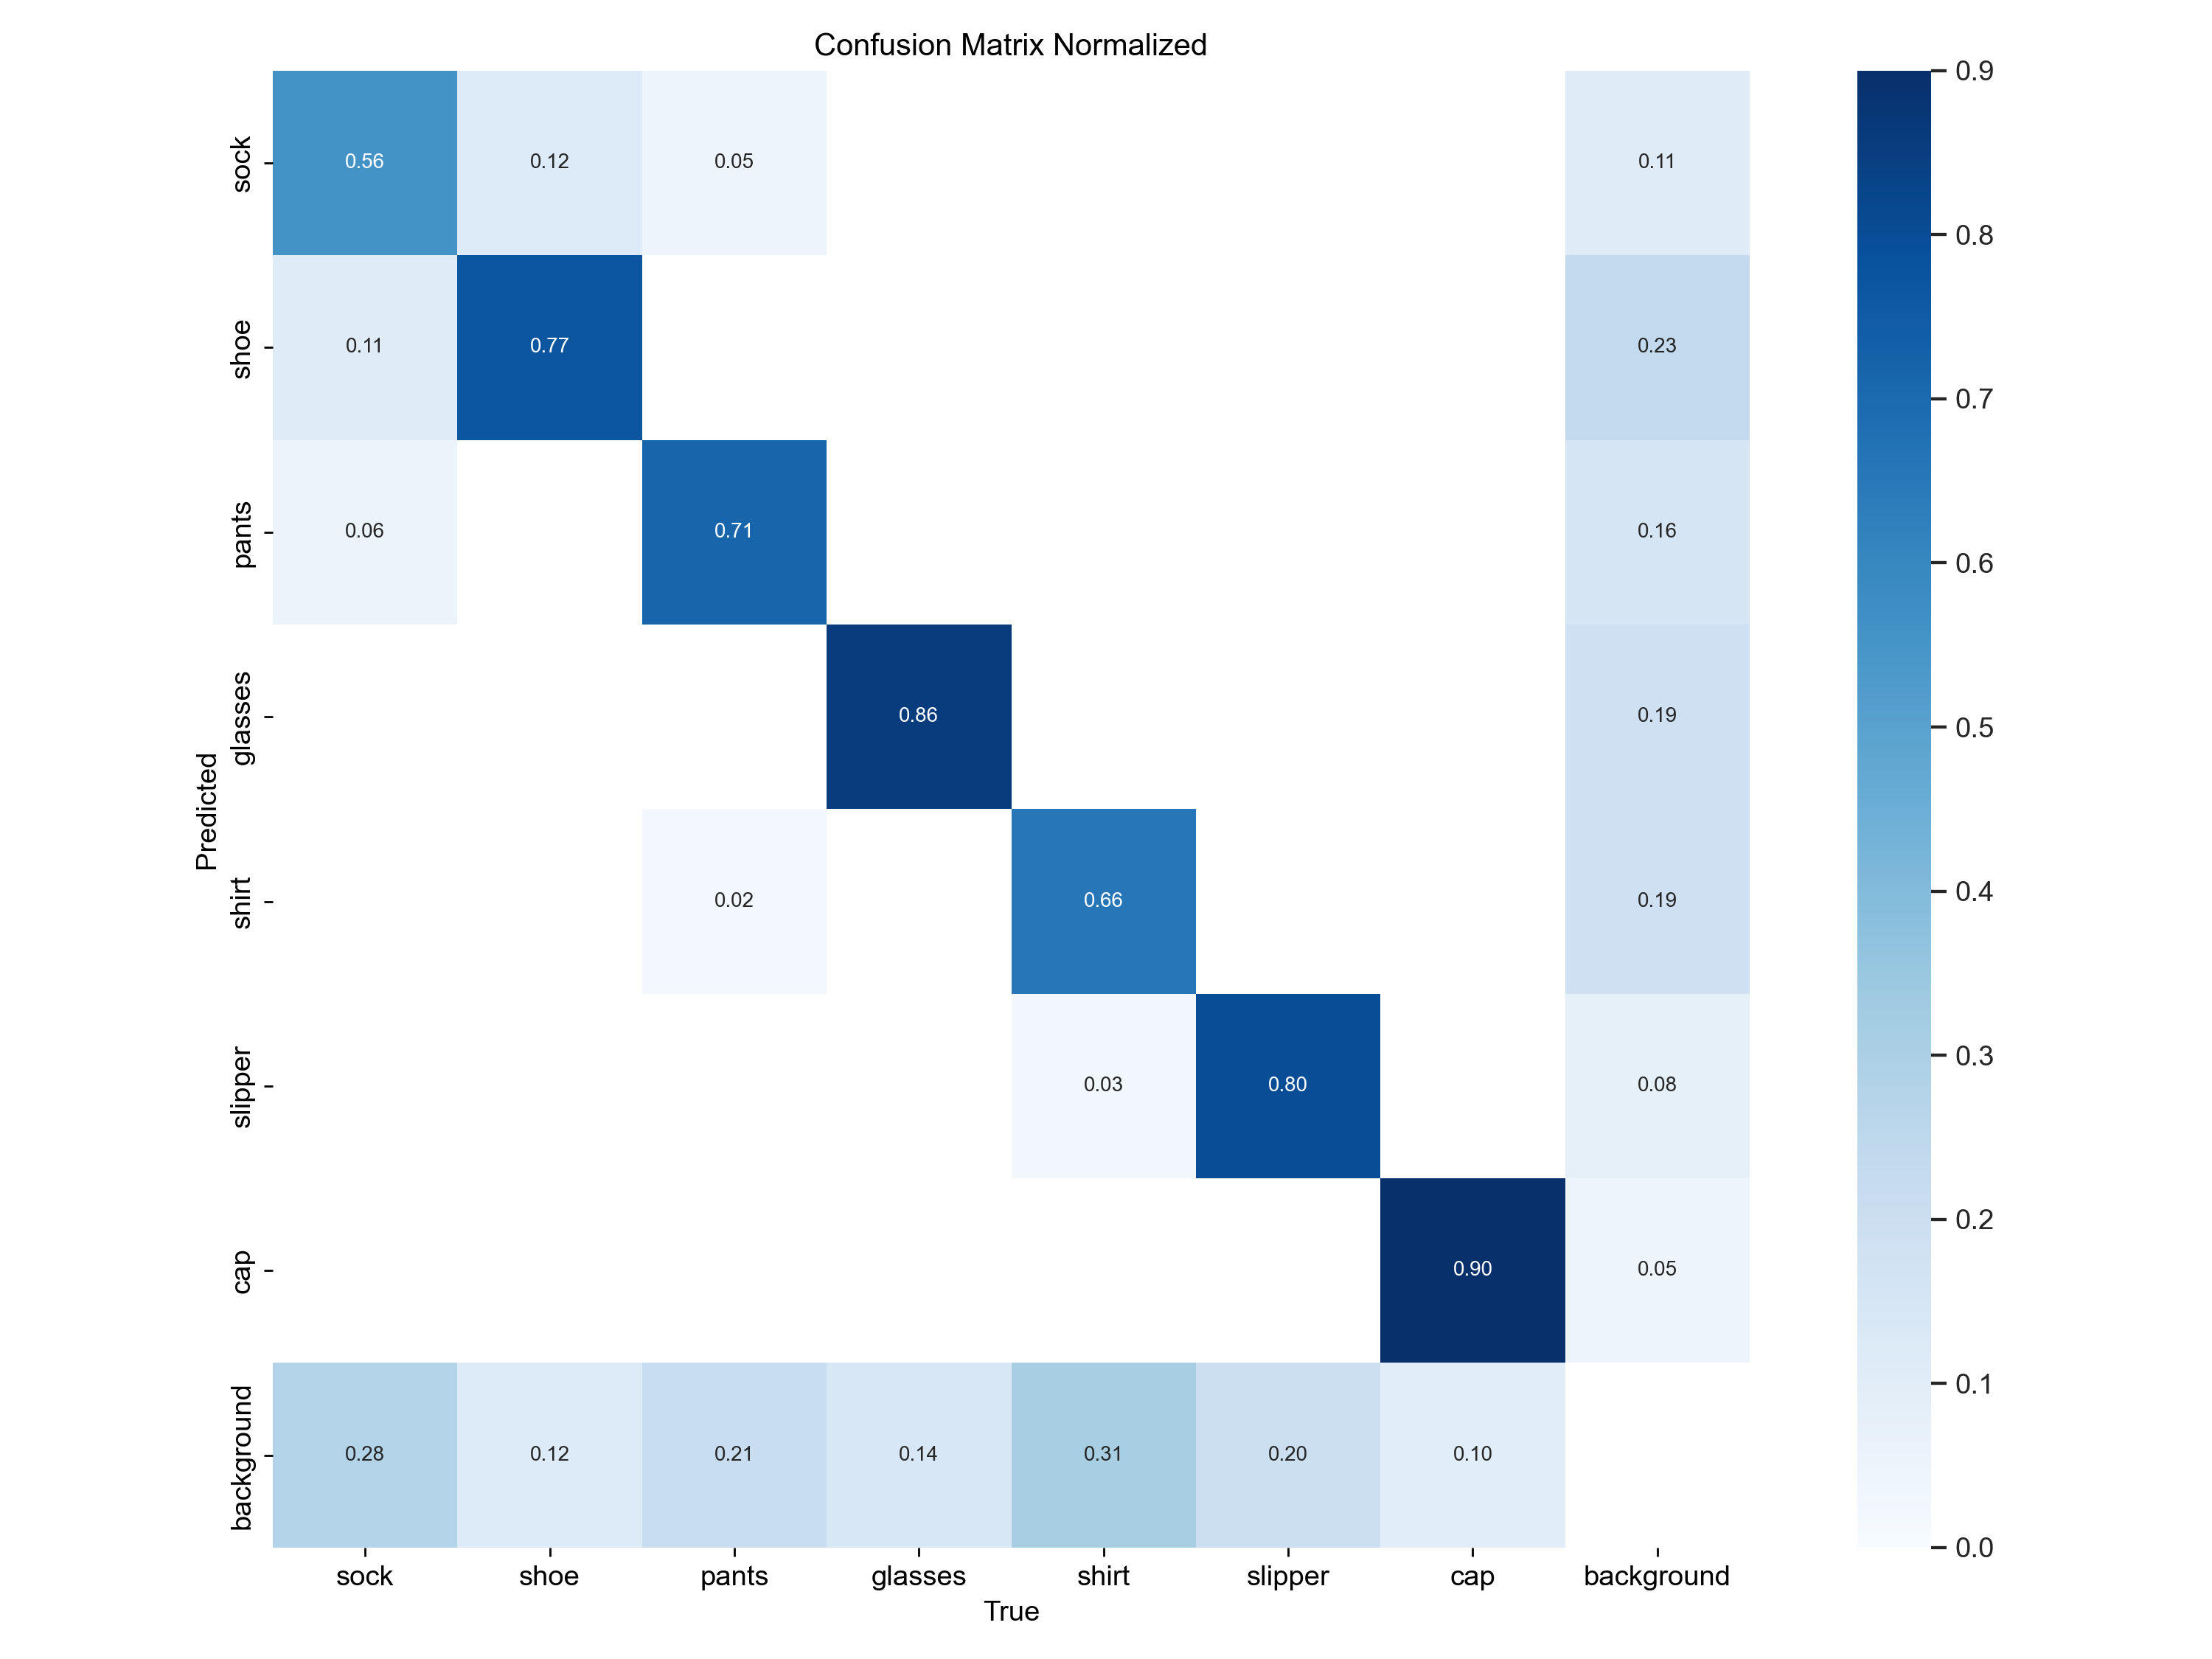

In [14]:
Image('runs/segment/val/confusion_matrix_normalized.png', width = 900)

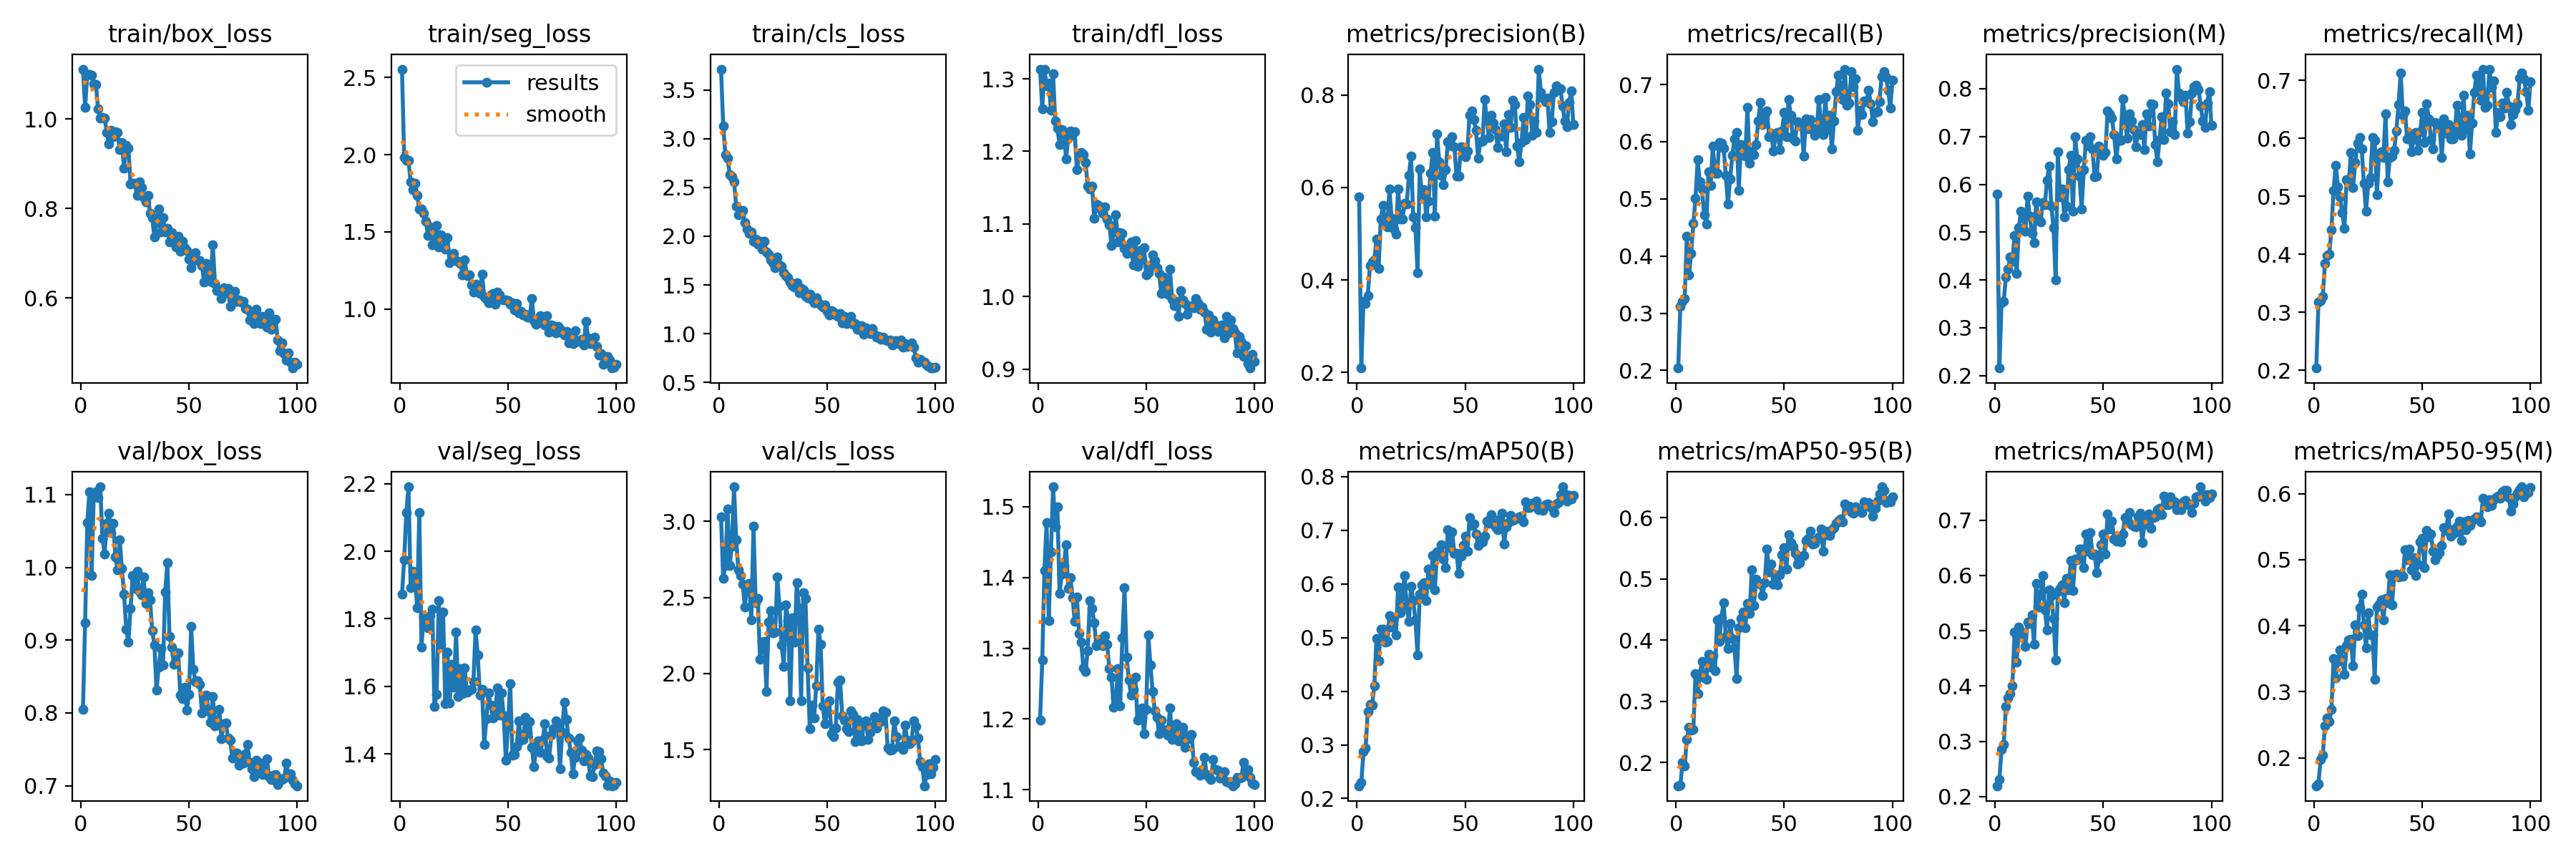

In [15]:
Image('runs/segment/train/results.png')

Based on the confusion matrix of predicted vs actual classes for the validation test, we can see that the model is able to segment the classes with accuracy between **56% to 90%**. The inaccuracies in predictions mainly comes from undetected objects rather than misclassifications.

From the training metric graphs, the training and validation losses are decreasing throughout training, which shows an improving model. Moreover, the losses have not plateaued after 100 epochs, indicating the model can further improve with additional epochs, which will further increase the mAP score.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Model Testing</span>

We will test the segmentation model on a few test images which represents real world detection performance:

<span style="font-size:18px; font-weight:bold;">Nano Model:</span>

In [15]:
model_n_seg_1.predict(source = 'test_images', save = True, conf = 0.1, line_width = 1);


image 1/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists.jpg: 640x544 3 socks, 4 shoes, 2 pantss, 2 glassess, 3 shirts, 1 cap, 100.0ms
image 2/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists2.jpg: 448x640 1 glasses, 89.0ms
image 3/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists3.jpeg: 416x640 1 shoe, 7 pantss, 4 shirts, 90.0ms
image 4/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists4.jpg: 448x640 1 pants, 3 glassess, 1 shirt, 2 caps, 16.0ms
Speed: 3.5ms preprocess, 73.8ms inference, 4.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\segment\predict


model_n_seg_1 Predictions:


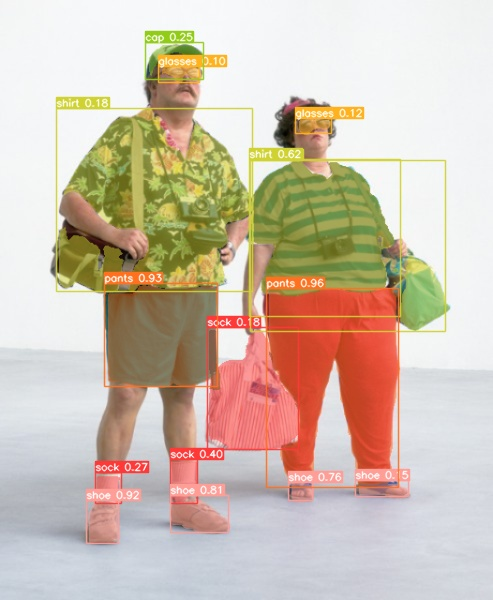

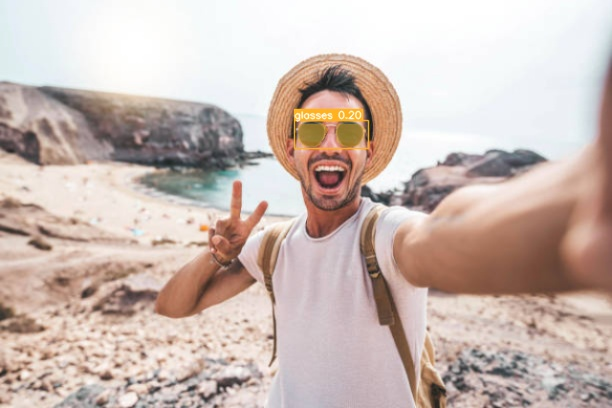

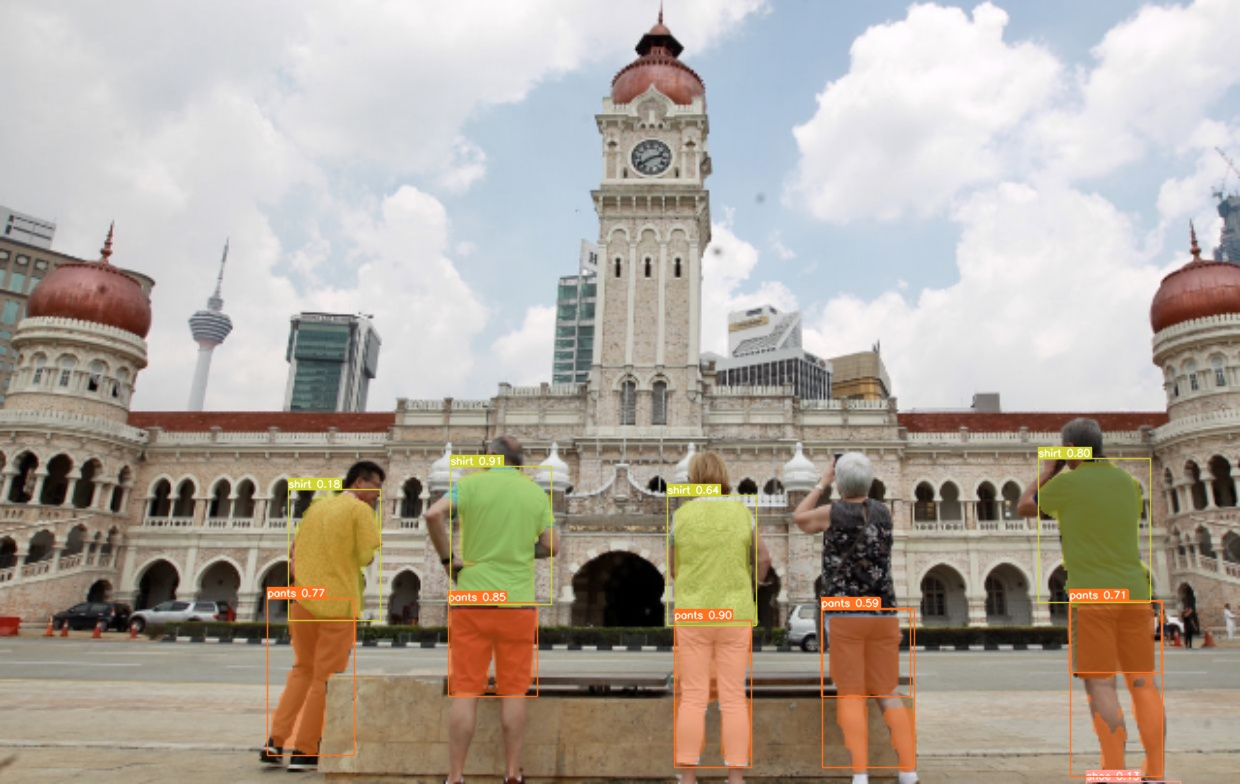

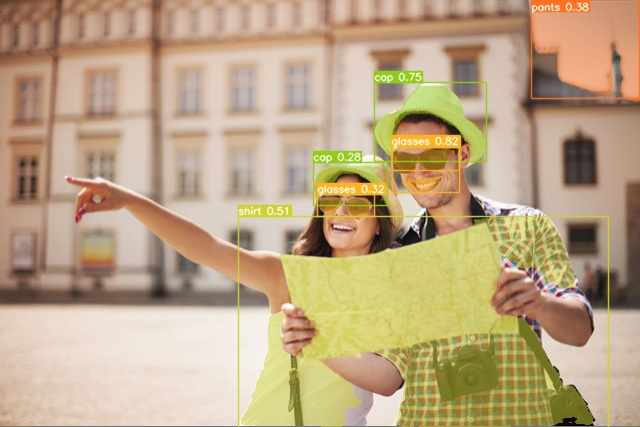

In [16]:
allowed_extensions = ['.jpg', '.jpeg', '.png']

print('model_n_seg_1 Predictions:')

for image_path in glob.glob('runs/segment/predict/*'):
    if any(image_path.lower().endswith(ext) for ext in allowed_extensions):
        display(Image(filename = image_path, height = 600))
        print()

In [ ]:
model_n_seg_1.predict(source = 'test_videos/Nautica Men s Spring 2014 Black Sail Fashion Show.mp4', save = True, conf = 0.3, line_width = 2);

The test results align with the validation results which states that most errors will come from undetected objects rather than misclassifications.

However, lots of objects are still detected with low confidence (<0.3). If the confidence threshold is increased, these objects will be missing from the segmentations. Hence, ideally the model should be trained with a larger dataset of wider variety for more epochs to achieve a better result.

<span style="font-size:18px; font-weight:bold;">Pre-Trained Model (baseline):</span>

We test the same images with the pre-trained model to have a direct comparison of the segmentation result. The pre-trained model has been trained using the COCO dataset which consist of clothing classes hat, shoe and eye glasses:

In [17]:
pretrained_YOLO_seg_nano = YOLO('yolov8n-seg.pt')

In [23]:
pretrained_YOLO_seg_nano.predict(source = 'test_images', save = True, conf = 0.2, line_width = 1);


image 1/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists.jpg: 640x544 2 persons, 2 handbags, 103.0ms
image 2/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists2.jpg: 448x640 1 person, 1 surfboard, 62.0ms
image 3/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists3.jpeg: 416x640 6 persons, 1 clock, 13.0ms
image 4/4 C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\test_images\tourists4.jpg: 448x640 4 persons, 1 handbag, 13.0ms
Speed: 2.8ms preprocess, 47.8ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\segment\predict2


pretrained_YOLO_seg_nano Predictions:


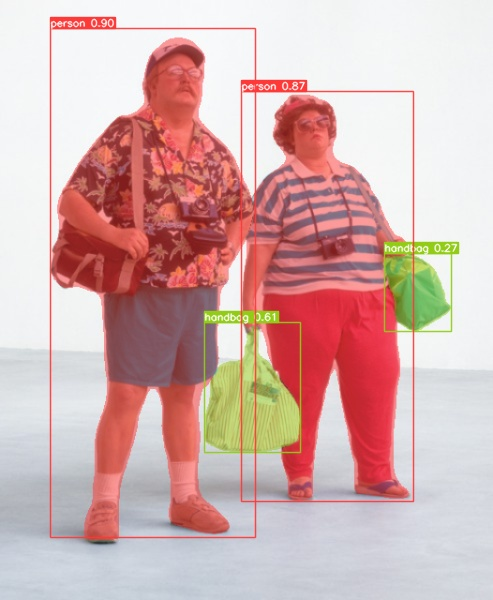

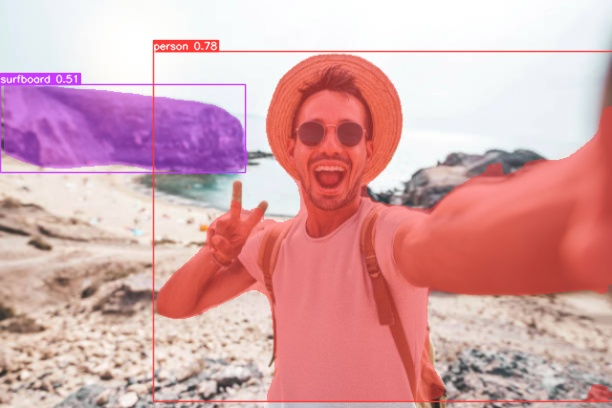

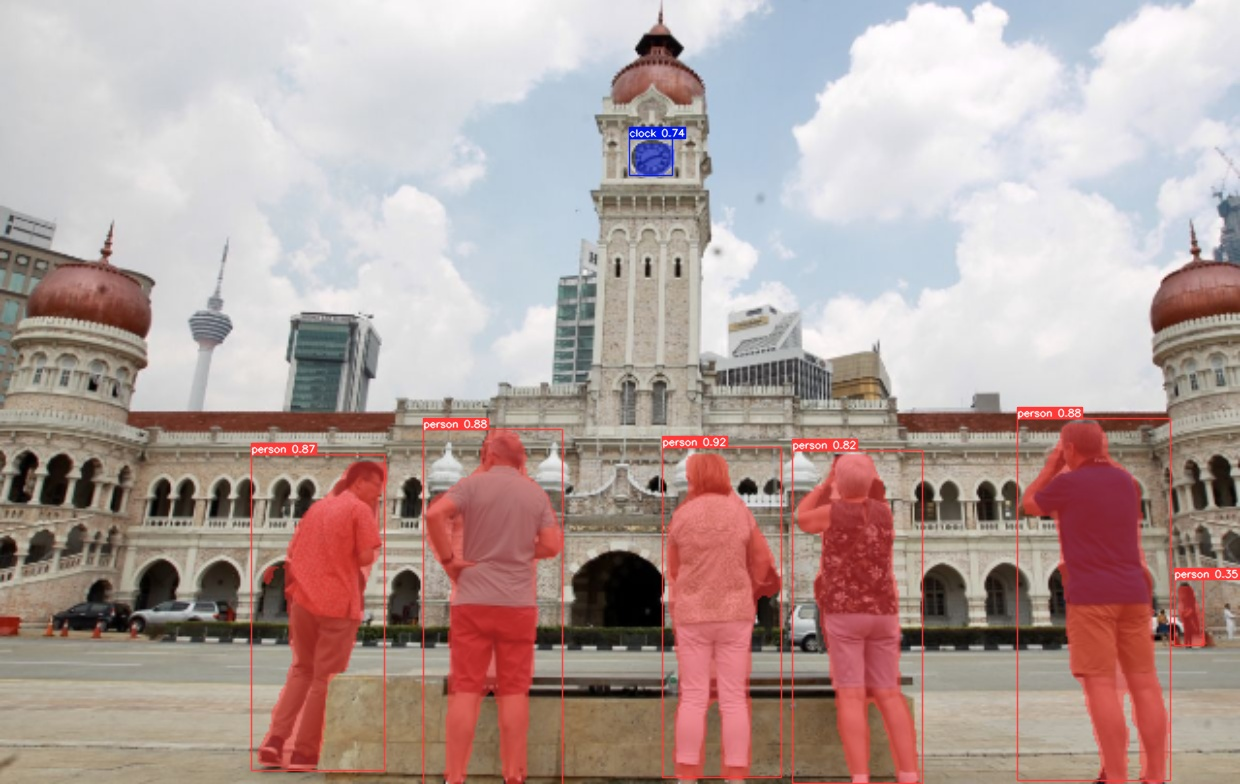

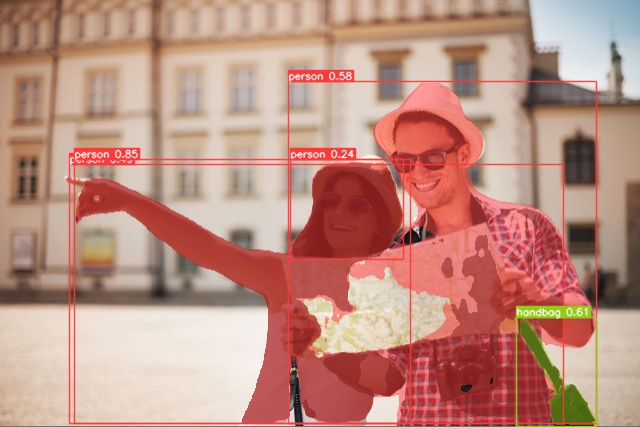

In [24]:
allowed_extensions = ['.jpg', '.jpeg', '.png']

print('pretrained_YOLO_seg_nano Predictions:')

for image_path in glob.glob('runs/segment/predict2/*'):
    if any(image_path.lower().endswith(ext) for ext in allowed_extensions):
        display(Image(filename = image_path, height = 600))
        print()

As the pre-trained model is trained on the COCO dataset consisting 80 classes, it segments an individual wearing a variety of clothing items as 'person' instead of individually segmenting the clothing items worn, which is the requirement of the project.

Additionally, this model also has misclassifications on object classes. This is to be expected as we are using the nano model instead of a larger model which will be more accurate with larger datasets at the cost of inference speed and computational resources required.

In order to obtain a higher accuracy segmentation model, a larger dataset and model could be used.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Further Training</span>

Further training on the custom-trained nano model **(model_n_seg_1)** for 100 epochs.

In [25]:
torch.cuda.empty_cache()

In [26]:
last_nano_seg_1 = 'runs/segment/train/weights/last.pt'
last_model_n_seg_1 = YOLO(last_nano_seg_1)

In [ ]:
last_model_n_seg_1.resume = True
last_model_n_seg_1.train(data = 'config.yaml',
                         epochs = 100,
                         batch = 1,
                         workers = 0,
                         seed = seed
                        )

In [9]:
best_nano_seg_2 = 'runs/segment/train2/weights/best.pt'
model_n_seg_2 = YOLO(best_nano_seg_2)

In [10]:
model_n_seg_2.val();

Ultralytics YOLOv8.1.3 🚀 Python-3.8.0 torch-1.9.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259429 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning C:\Users\xiani\Desktop\Online Studies\Deep Learning Project\Clothing Segmentation (YOLOv8)\data\val\label
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAPException in thread Thread-76:
Traceback (most recent call last):
  File "C:\Users\xiani\anaconda3\envs\tf_gpu\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\xiani\anaconda3\envs\tf_gpu\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\xiani\anaconda3\envs\tf_gpu\lib\site-packages\ultralytics\utils\plotting.py", line 759, in plot_images
    im = np.asarray(annotator.im).copy()
numpy.core._exceptions.MemoryError: Unable to allocate 10.5 MiB for an array with shape (1920, 1920, 3) and data type uint8
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAPException in thread Thread-79:
Traceback (most recent c

                   all         71        186      0.831       0.71      0.795      0.666      0.818        0.7       0.77      0.632
                  sock         71         18      0.766      0.667      0.684       0.49      0.765      0.667      0.684      0.491
                  shoe         71         43      0.868      0.764      0.809      0.636      0.842      0.741      0.769      0.613
                 pants         71         42      0.883      0.571       0.82      0.689      0.883      0.571       0.83      0.676
               glasses         71         21      0.947      0.857      0.876      0.687      0.947      0.857      0.861      0.698
                 shirt         71         32      0.756      0.582       0.69      0.642      0.756      0.582      0.681      0.623
               slipper         71         20      0.936      0.731      0.909      0.747      0.872      0.681      0.786      0.582
                   cap         71         10      0.659        0.8   

After an additional training of 100 epochs, the mAP val 50-95 score has increased to 63.2%

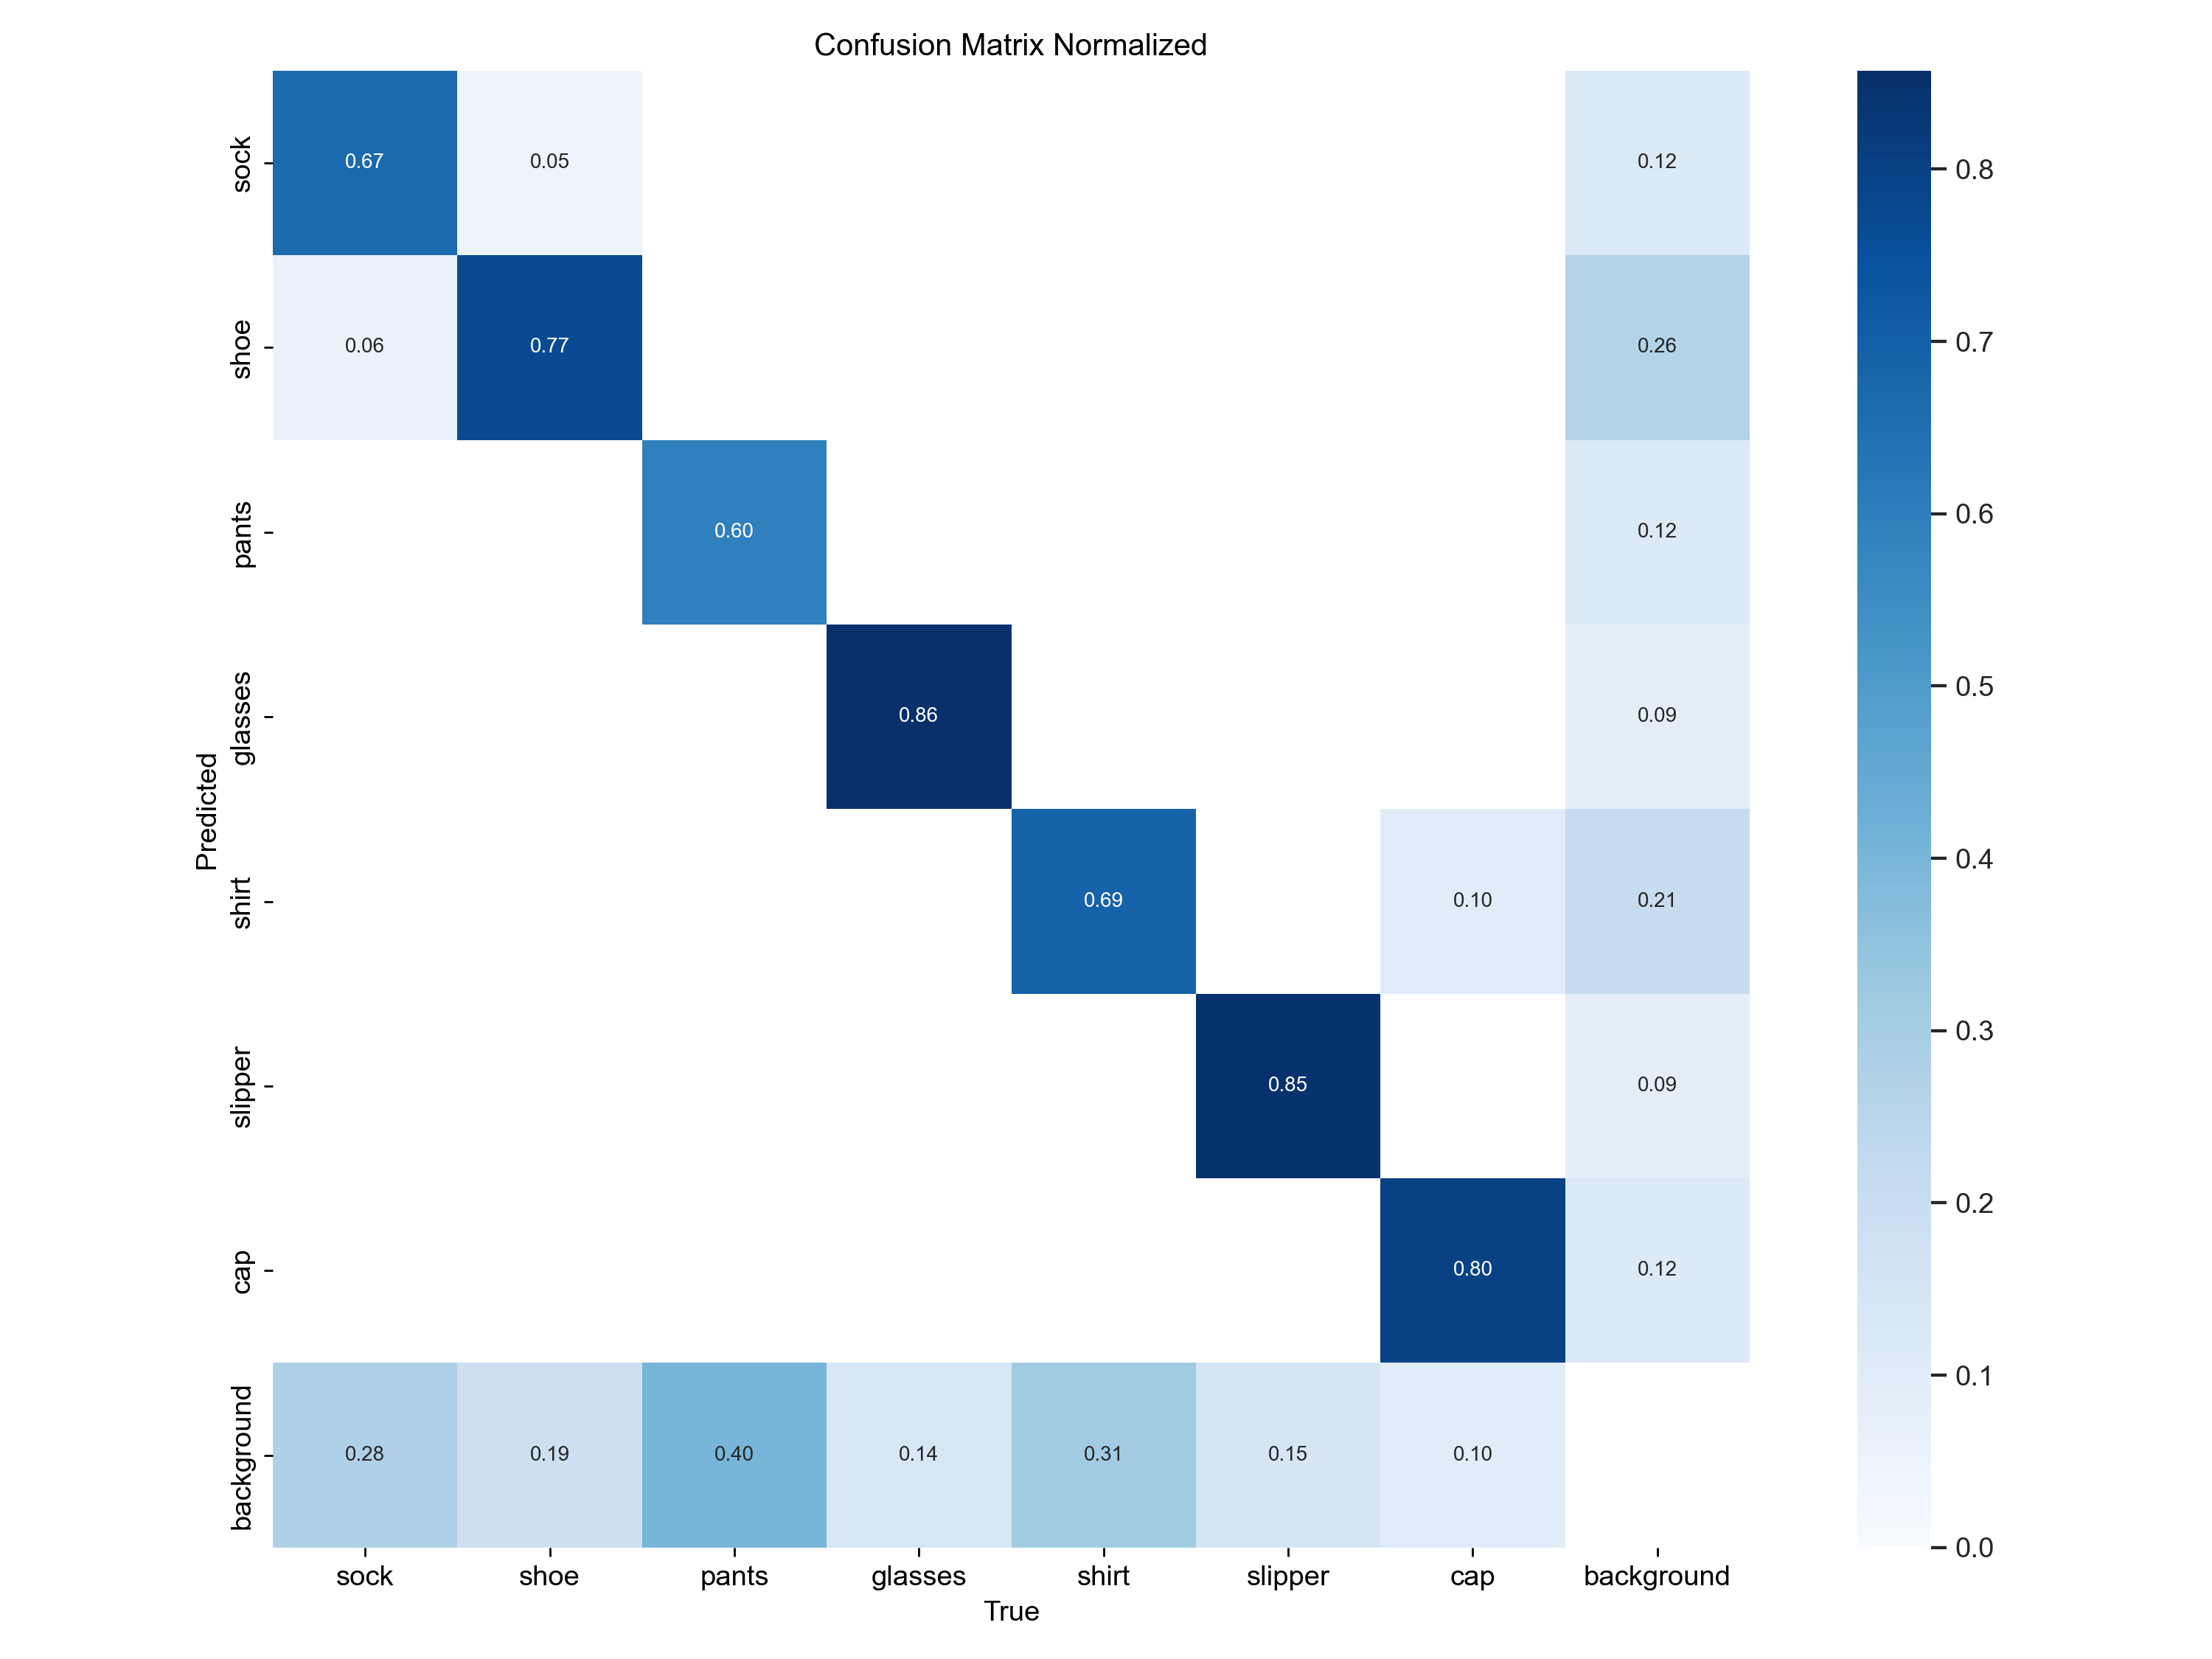

In [11]:
Image('runs/segment/val2/confusion_matrix_normalized.png', width = 900)

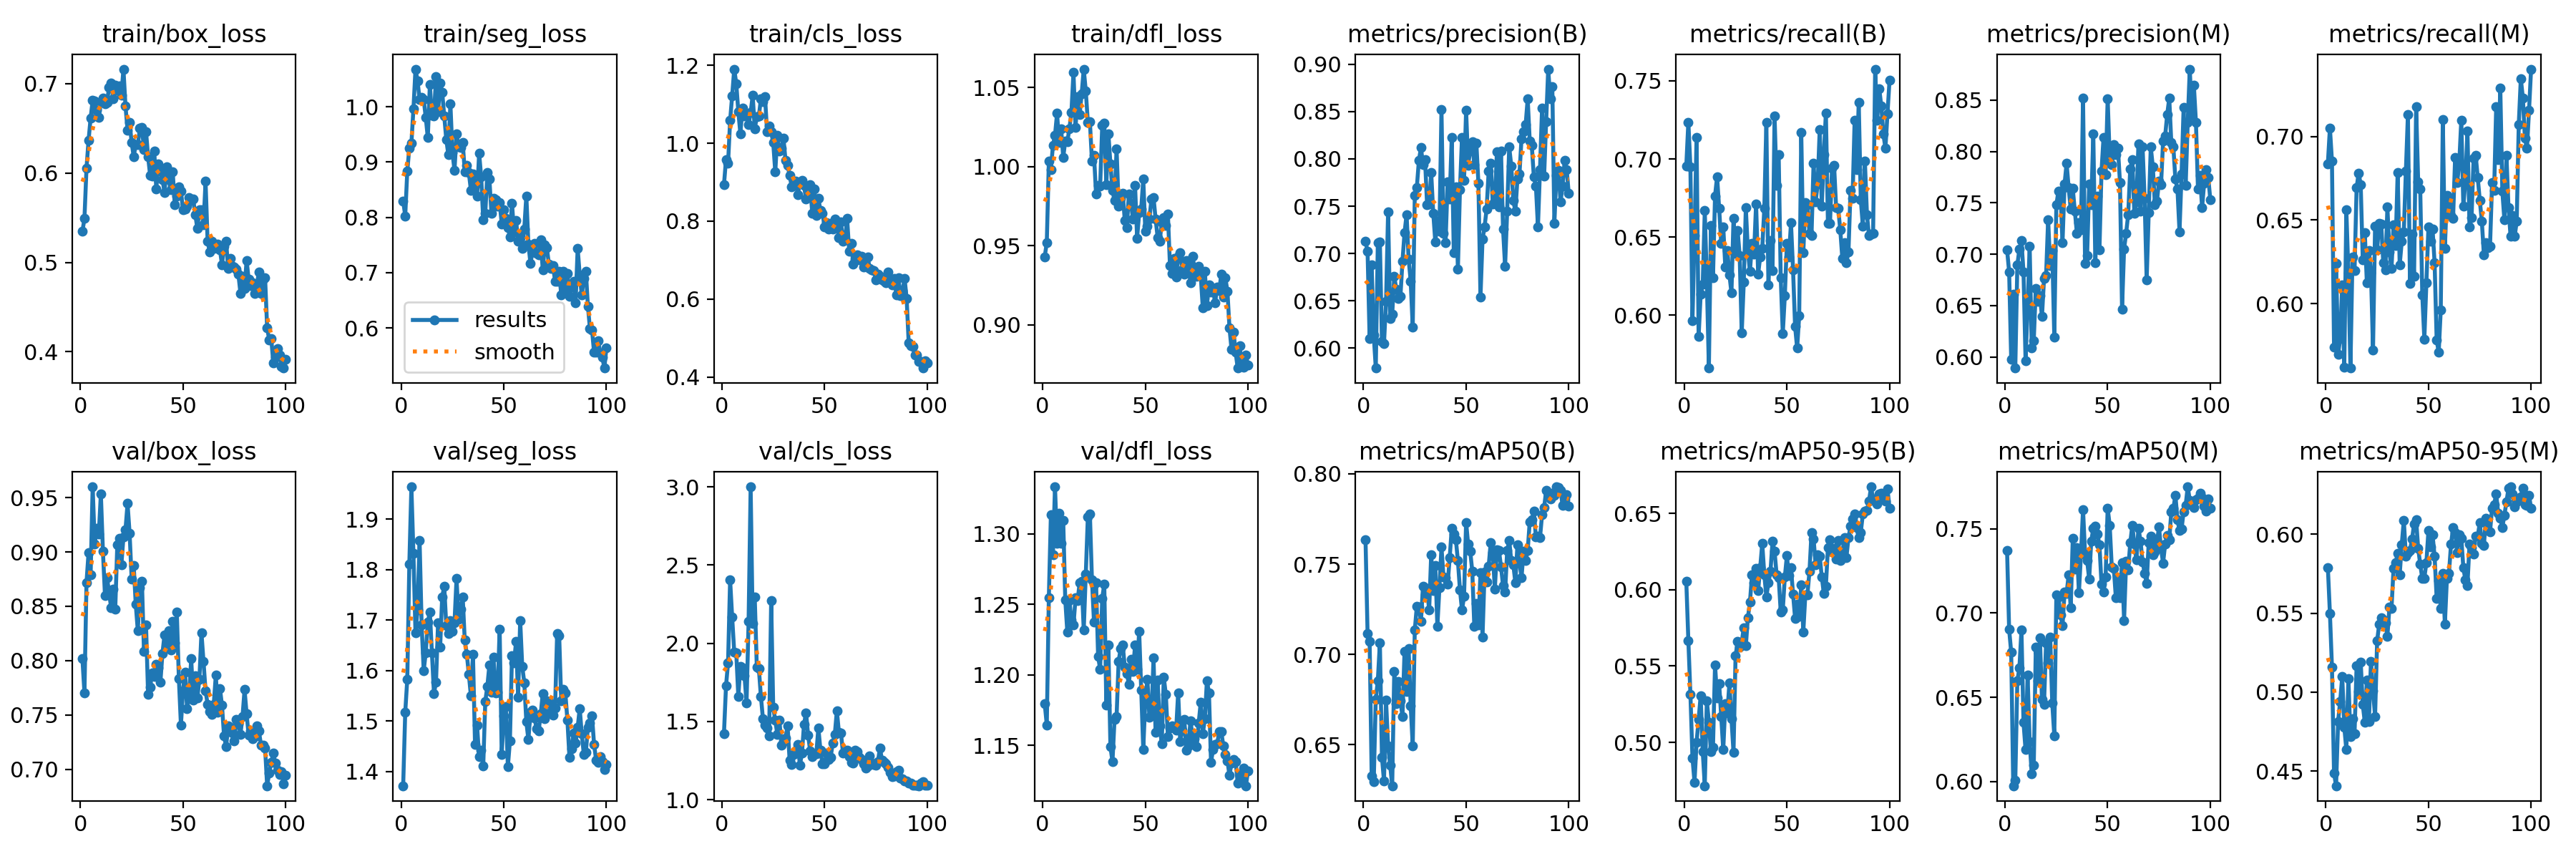

In [12]:
Image('runs/segment/train2/results.png')

There is now lesser missing segmentations and higher minimum accuracy of 60%. Further training could still improve the model.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Model Development</span>

The outfit scoring application is developed using the custom trained segmentation model:

In [13]:
from ultralytics import YOLO

best_nano_seg_2 = 'runs/segment/train2/weights/best.pt'
model_n_seg_2 = YOLO(best_nano_seg_2)

In [14]:
class segmentYOLO:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
    
    def detect(self, img, conf):
        height, width, channels = img.shape
        
        results = self.model.track(source = img.copy(), conf = conf, persist = True)
        results = results[0]
        
        segmentation_contours_idx = []
        track_ids = []
        
        if results.masks is not None:
            for seg in results.masks.xy:
                segment = np.array(seg, dtype = np.int32)
                segmentation_contours_idx.append(segment)

            bboxes = results.boxes.xyxy.cpu().numpy().astype(int)
            class_ids = results.boxes.cls.cpu().numpy().astype(int)
            scores = results.boxes.conf.cpu().numpy()
            if results.boxes.id is not None:
                track_ids = results.boxes.id.cpu().numpy().astype(int)
            else:
                pass
            return bboxes, class_ids, segmentation_contours_idx, scores, track_ids
        else:
            return [], [], [], [], []
    
    def generate_color_map(self):
        color_map = {}
        saturation = 0.8
        value = 0.8
        num_class = len(list(self.model.names.values()))
        hue_step = 1.0 / num_class
        hue_start = random.random()
    
        for i in range(num_class):
            hue = (hue_start + i * hue_step) % 1.0
            r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
            color_map[i] = tuple(int(x * 255) for x in (r, g, b))
        return color_map

In [ ]:
# Software

# cap = cv2.VideoCapture('test_videos/trimmed_cropped.mp4')
cap = cv2.VideoCapture(0)

# Segmentation detector
seg_yolo = segmentYOLO(best_nano_seg_2)

# Class & colour generator
yolo_classes = list(seg_yolo.model.names.values())
yolo_classes_organized = ['pants', 'shirt', 'shoe', 'cap', 'glasses', 'sock', 'slipper']
color_map = seg_yolo.generate_color_map()

# Mask
# mask = cv2.imread('data-notebook/mask.jpg')
mask = cv2.imread('data-notebook/mask_cam.jpg')

# Overlay
overlay_image = cv2.imread('data-notebook/overlay1.1_transparent.png', cv2.IMREAD_UNCHANGED)

# Clothing score dictionary
clothing_score = {}

# Create output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, 15, (int(cap.get(3)), int(cap.get(4))))

##### FRAME LOOP #####
while True:
    ret, img = cap.read()
    if not ret:
        break
        
    img_region = cv2.bitwise_and(img, mask)

    cvzone.overlayPNG(img, overlay_image, pos = [0, 0])

    current_clothes = []
    duo_detect = ['shoe', 'sock', 'slipper']
    duo_clothing_score = {'shoe': [0], 'sock': [0], 'slipper': [0]}
    last_track_id = {}

    bboxes, classes, segmentations, scores, track_ids = seg_yolo.detect(img_region, 0.3)
    for bbox, class_id, seg, score, track_id in zip(bboxes, classes, segmentations, scores, track_ids):
        (x, y, x2, y2) = bbox
        w, h = x2 - x, y2 - y
        cx, cy = (x + (w // 2)), (y + (h // 2))

        class_color = color_map[class_id]
        class_name  = yolo_classes[class_id]
        current_clothes.append(class_name)
        last_track_id[class_name] = track_id

        # Fill segmentation poly
        overlay = img.copy()
        cv2.fillPoly(overlay, [seg], class_color)
        alpha = 0.5
        img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

        # Clothing score
        score_ranges = {
            'shirt': (20, 30),
            'pants': (20, 30),
            'cap': (5, 10),
            'shoe': (5, 10),
            'glasses': (1, 5),
            'sock': (1, 5),
            'slipper': (1, 5)
        }

        if track_id not in clothing_score:
            if class_name in score_ranges:
                min_score, max_score = score_ranges[class_name]
                clothing_score[track_id] = random.randint(min_score, max_score)

        if class_name in duo_detect:
            duo_clothing_score[class_name].append(clothing_score[track_id])
            
        # Indicator lines, track ID and class text
        # 'class': ((hori_line_1), (hori_line_2), (line_colour), (track_id_pos), (clothing_score_pos))
        parameters = {
            'cap': ((131, 68), (150, 68), (87, 76, 38), (36, 47), (86, 75)),
            'glasses': ((506, 120), (487, 120), (159, 193, 45), (590, 100), (523, 127)),
            'shirt': ((131, 180), (150, 180), (87, 76, 38), (36, 159), (86, 187)),
            'pants': ((506, 240), (487, 240), (51, 58, 215), (590, 220), (523, 247)),
            'sock': ((131, 293), (150, 293), (91, 194, 255), (36, 271), (86, 299)),
            'slipper': ((506, 360), (487, 360), (159, 193, 45), (590, 340), (523, 367)),
            'shoe': ((131, 405), (150, 405), (42, 183, 239), (36, 383), (86, 411))
        }

        if class_name in parameters:
            hori_line_1, hori_line_2, line_colour, track_id_pos, clothing_score_pos = parameters[class_name]
            cv2.line(img, hori_line_1, hori_line_2, line_colour, 2)
            cv2.line(img, hori_line_2, (cx, cy), line_colour, 2)
            cv2.putText(img, f'{last_track_id[class_name]}', track_id_pos, cv2.FONT_HERSHEY_TRIPLEX, fontScale = 0.6, color = (255, 255, 255), thickness = 1)
            if class_name not in duo_detect:
                cv2.putText(img, f'{clothing_score[track_id]}', clothing_score_pos, cv2.FONT_HERSHEY_TRIPLEX, fontScale = 0.9, color = (255, 255, 255), thickness = 2)
            else:
                # Class text (duo)
                cv2.putText(img, f'{sum(duo_clothing_score[class_name])}', clothing_score_pos, cv2.FONT_HERSHEY_TRIPLEX, fontScale = 0.9, color = (255, 255, 255), thickness = 2)
            
        # Segmentation midpoint
        cv2.circle(img, (cx, cy), 4, (255, 255, 255), cv2.FILLED)

    # Clothing recommendation
    missing_clothes = [item for item in yolo_classes_organized if item not in current_clothes]
    
    total_clothing_score = sum(clothing_score[track_id] for track_id in track_ids)

    if 'shoe' in current_clothes or 'slipper' in current_clothes:
        missing_clothes = [item for item in missing_clothes if item not in ['shoe', 'slipper', 'sock']]
        
    missing_clothes_str = missing_clothes[0] if missing_clothes else ''
    
    # Text (UI)
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 0.7
    thickness = 1
    x = 0
    y = 33    
    if missing_clothes_str == '' or total_clothing_score >= 80:
        cv2.putText(img, 'PERFECT!', (245, 440), font, 1, (0, 0, 0), 2)
    else:
        # Centered text
        text = f'Add a {missing_clothes_str}!'
        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
        text_w, text_h = text_size
        middle_point_x = x + (img.shape[1] - text_w) // 2
        cv2.putText(img, text, (middle_point_x, 433), font, font_scale, (0, 0, 0), thickness)
    
    # Centered score text
    text_score = f'{total_clothing_score}'
    font_score = cv2.FONT_HERSHEY_TRIPLEX
    font_scale_score = 1
    
    if total_clothing_score >= 80:
        color_score = (0, 255, 0)
    elif total_clothing_score < 40:
        color_score = (0, 0, 255)
    else:
        color_score = (0, 0, 0)
    
    thickness_score = 2
    x_score = 0
    y_score = 33
    text_size_score = cv2.getTextSize(text_score, font_score, font_scale_score, thickness_score)[0]
    text_w_score, text_h_score = text_size_score
    middle_point_x_score = x_score + (img.shape[1] - text_w_score) // 2
    cv2.putText(img, text_score, (middle_point_x_score, y_score), font_score, font_scale_score, color_score, thickness_score)
    
    output_video.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    cv2.imshow('Image', img)
    cv2.waitKey(1)

cap.release()
output_video.release()
cv2.destroyAllWindows()

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Features</span>

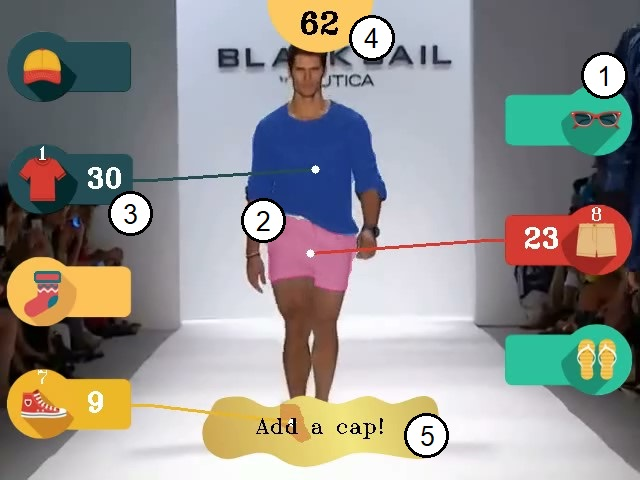

In [16]:
Image('data-notebook/output_video2-frame-labeled.jpg', width = 500)

<span style="font-size:18px; font-weight:bold;">1. Clothing Segmentation:</span>

Real time segmentation of 7 classes.

<span style="font-size:18px; font-weight:bold;">2. Auto Colour Generation:</span>

Automatically generates distinct colours for each segmentation class based on the number of classes trained.

<span style="font-size:18px; font-weight:bold;">3. Individual Class Tabs:</span>

Each class UI displays:
- Track ID of current object
- Score of particular clothing
- Auto tracking on position of segmented clothing

<span style="font-size:18px; font-weight:bold;">4. Scoring System:</span>

Each clothing worn is scored within a range based on its class and the total outfit score is displayed.

<span style="font-size:18px; font-weight:bold;">5. Recommendation System:</span>

Recommends clothing to add to enhance outfit score based on what clothing is worn.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Final Result</span>

Real time inference of the application:

*The final result video is available in the data-notebook folder.

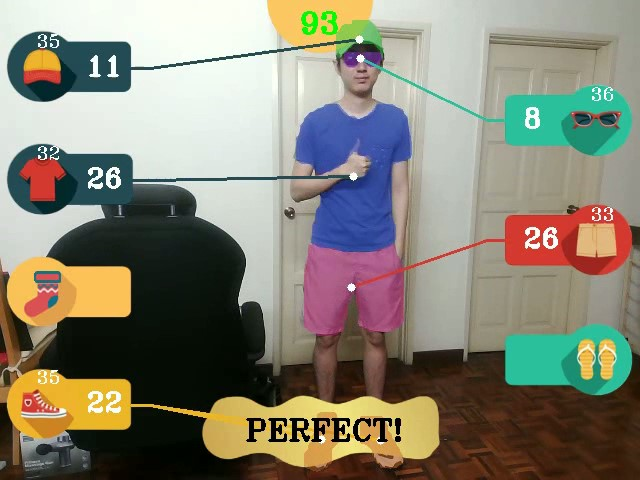

In [17]:
Image('data-notebook/outfit_scoring_frame.jpg')